In [ ]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import os
import csv
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from pydriller import Repository


In [ ]:
# ------------------------------
# Helpers
# ------------------------------

def clean_diff(diff_text) -> str:
    """Clean diff by removing metadata and whitespace-only differences."""
    if diff_text is None or not isinstance(diff_text, str):
        return ""
    cleaned = []
    for line in diff_text.splitlines():
        line = line.strip()
        if not line:
            continue
        if line.startswith(("diff --git", "index", "---", "+++", "@@")):
            continue
        cleaned.append(line)
    return "\n".join(cleaned)


def categorize_file(path: str) -> str:
    """Categorize file as Source, Test, README, LICENSE, or Other."""
    if path is None or (isinstance(path, float) and pd.isna(path)):
        return "Other"
    path_lower = str(path).lower()
    if "test" in path_lower or path_lower.startswith("test_") or "/test/" in path_lower:
        return "Test"
    if "readme" in path_lower:
        return "README"
    if "license" in path_lower:
        return "LICENSE"
    if path_lower.endswith((".py", ".java", ".cpp", ".c", ".js", ".ts", ".go")):
        return "Source"
    return "Other"

def run_git_diff(repo_path: str, parent: str, commit: str, file_path: str, algo: str) -> str:
    """Run git diff with given algorithm (myers/histogram), ignoring whitespace/blank lines."""
    if parent == "None" or file_path is None:
        return ""
    result = subprocess.run(
        ["git", "-C", repo_path, "diff", "-w", "--ignore-blank-lines",
         f"--diff-algorithm={algo}", parent, commit, "--", file_path],
        capture_output=True, text=True
    )
    return clean_diff(result.stdout)

In [ ]:
# ------------------------------
# Step (c): Extract repo → dataset.csv
# ------------------------------

def extract_dataset(repo_url: str, local_path: str, dataset_file: str):
    """Extract commits and modified files from one repo into dataset.csv"""
    # Clone locally if not exists
    if not os.path.exists(local_path):
        subprocess.run(["git", "clone", repo_url, local_path])

    with open(dataset_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "old_file_path", "new_file_path",
            "commit_SHA", "parent_commit_SHA",
            "commit_message", "diff_myers", "diff_hist"
        ])
        for commit in Repository(local_path).traverse_commits():
            parent_commits = commit.parents if commit.parents else ["None"]
            parent = parent_commits[0]

            for m in commit.modified_files:
                file_path = m.new_path or m.old_path
                diff_myers = run_git_diff(local_path, parent, commit.hash, file_path, "myers")
                diff_hist = run_git_diff(local_path, parent, commit.hash, file_path, "histogram")

                writer.writerow([
                    m.old_path, m.new_path,
                    commit.hash, parent,
                    commit.msg.strip(),
                    diff_myers, diff_hist
                ])
    print(f"dataset written to {dataset_file}")

In [ ]:
# ------------------------------
# Step (d): Add discrepancy → final_dataset.csv
# ------------------------------

def add_discrepancy(dataset_file: str, final_file: str):
    df = pd.read_csv(dataset_file)
    df["Discrepancy"] = [
        "No" if clean_diff(row["diff_myers"]) == clean_diff(row["diff_hist"]) else "Yes"
        for _, row in df.iterrows()
    ]
    df["Category"] = df.apply(lambda row: categorize_file(row["new_file_path"] or row["old_file_path"]), axis=1)
    df.to_csv(final_file, index=False)
    print(f"final dataset written to {final_file}")

In [ ]:
# ------------------------------
# Step (e): Stats + plot
# ------------------------------

def generate_stats(final_file: str, plot_file: str):
    df = pd.read_csv(final_file)
    mismatches = df[df["Discrepancy"] == "Yes"]
    stats = {
        "Source": (mismatches["Category"] == "Source").sum(),
        "Test": (mismatches["Category"] == "Test").sum(),
        "README": (mismatches["Category"] == "README").sum(),
        "LICENSE": (mismatches["Category"] == "LICENSE").sum(),
    }
    print("\n--- Mismatch Statistics ---")
    for k, v in stats.items():
        print(f"{k}: {v}")

    plt.bar(stats.keys(), stats.values())
    plt.title("Mismatch Counts by File Type")
    plt.xlabel("File Category")
    plt.ylabel("# Mismatches")
    plt.tight_layout()
    plt.savefig(plot_file)
    plt.show()
    print(f"plot saved as {plot_file}")


In [ ]:
# ------------------------------
# Step (f): Algorithm comparison explanation
# ------------------------------

def algorithm_comparison(final_file: str):
    df = pd.read_csv(final_file)
    mismatches = df[df["Discrepancy"] == "Yes"]
    if len(mismatches) == 0:
        conclusion = "Both algorithms produced identical results (no mismatches)."
        print("\n--- Algorithm Comparison ---")
        print(conclusion)


dataset written to dataset_repo1.csv
final dataset written to final_dataset_repo1.csv

--- Mismatch Statistics ---
Source: 221
Test: 3
README: 8
LICENSE: 0


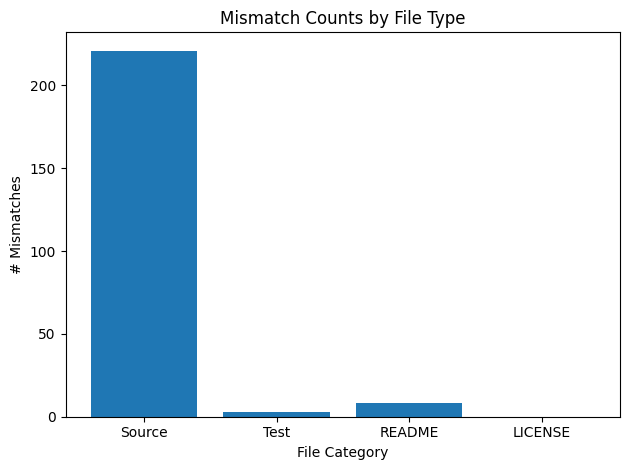

plot saved as mismatch_stats_repo1.png
Discrepancy Counts:
Yes: 272
No: 10367


In [ ]:
# ------------------------------
# MAIN: Run for repo
# ------------------------------
repo_url = "https://github.com/9001/copyparty.git"
local_path = "copyparty"
tag = "repo1"

dataset_file = f"dataset_{tag}.csv"
final_file = f"final_dataset_{tag}.csv"
plot_file = f"mismatch_stats_{tag}.png"

extract_dataset(repo_url, local_path, dataset_file)
add_discrepancy(dataset_file, final_file)
generate_stats(final_file, plot_file)
algorithm_comparison(final_file)

# Example: if you already have a dataframe `df` with a column "discrepancy"
df = pd.read_csv("final_dataset_repo1.csv")

# Count number of yes and no
counts = df['Discrepancy'].value_counts()

print("Discrepancy Counts:")
yes_count = counts.get("Yes", 0)
no_count = counts.get("No", 0)

print(f"Yes: {yes_count}")
print(f"No: {no_count}")

dataset written to dataset_repo2.csv
final dataset written to final_dataset_repo2.csv

--- Mismatch Statistics ---
Source: 98
Test: 17
README: 10
LICENSE: 0


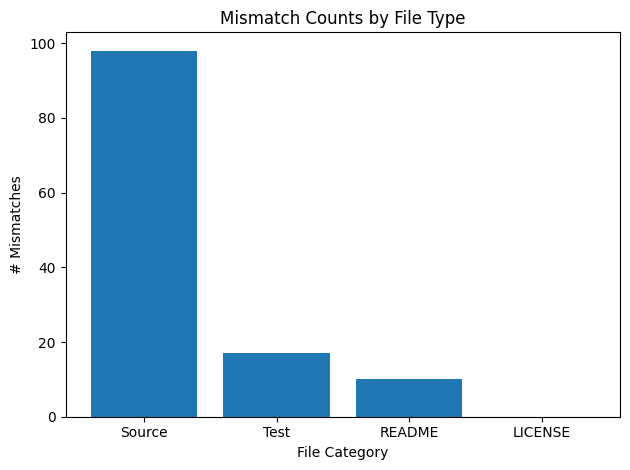

plot saved as mismatch_stats_repo2.png
Discrepancy Counts:
Yes: 131
No: 3071


In [16]:
# ------------------------------
# MAIN: Run for repo (deepface)
# ------------------------------
repo_url = "https://github.com/serengil/deepface.git"
local_path = "deepface"
tag = "repo2"

dataset_file = f"dataset_{tag}.csv"
final_file = f"final_dataset_{tag}.csv"
plot_file = f"mismatch_stats_{tag}.png"

extract_dataset(repo_url, local_path, dataset_file)
add_discrepancy(dataset_file, final_file)
generate_stats(final_file, plot_file)
algorithm_comparison(final_file)

# Example: if you already have a dataframe `df` with a column "Discrepancy"
df = pd.read_csv(final_file)

# Count number of Yes and No
counts = df['Discrepancy'].value_counts()

print("Discrepancy Counts:")
yes_count = counts.get("Yes", 0)
no_count = counts.get("No", 0)

print(f"Yes: {yes_count}")
print(f"No: {no_count}")


dataset written to dataset_repo3.csv
final dataset written to final_dataset_repo3.csv

--- Mismatch Statistics ---
Source: 317
Test: 215
README: 13
LICENSE: 1


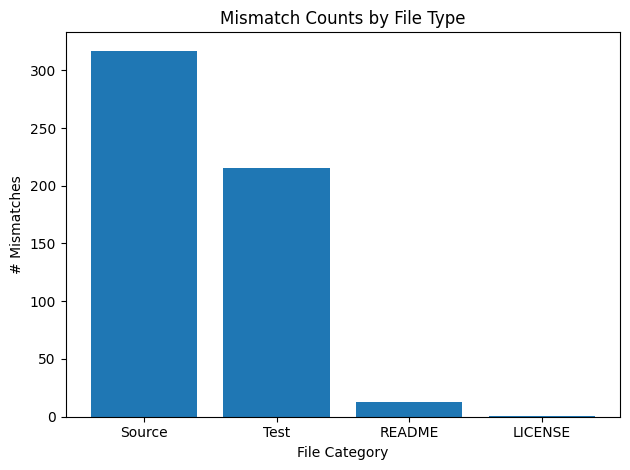

plot saved as mismatch_stats_repo3.png
Discrepancy Counts:
Yes: 558
No: 20892


In [17]:
# ------------------------------
# MAIN: Run for repo (python-telegram-bot)
# ------------------------------
repo_url = "https://github.com/python-telegram-bot/python-telegram-bot.git"
local_path = "python-telegram-bot"
tag = "repo3"

dataset_file = f"dataset_{tag}.csv"
final_file = f"final_dataset_{tag}.csv"
plot_file = f"mismatch_stats_{tag}.png"

extract_dataset(repo_url, local_path, dataset_file)
add_discrepancy(dataset_file, final_file)
generate_stats(final_file, plot_file)
algorithm_comparison(final_file)

# Example: if you already have a dataframe `df` with a column "Discrepancy"
df = pd.read_csv(final_file)

# Count number of Yes and No
counts = df['Discrepancy'].value_counts()

print("Discrepancy Counts:")
yes_count = counts.get("Yes", 0)
no_count = counts.get("No", 0)

print(f"Yes: {yes_count}")
print(f"No: {no_count}")
